## Reaction:

$m \to m + G, \text{rate}: k_{TL} * [m]$

$G \to 0    , \text{rate}: \xi$

$m \to 0    , \text{rate}: \delta$
 
## State of the system:
$X = [X_1, X_2]$ with

$X_1 = [G]$: eGFP concentration

$X_2 = [m]$: mRNA concentration

## Dynamics:

$\frac{d}{dt}X_2 = -\delta * X_2$

$\frac{d}{dt}X_1 = k_{TL} * X_2 - \xi * X_1$

## Measurement:
$Y = X_2$

## Observables of the system:
$y(t) = h(\theta, x(t))$

In [1]:
import pypesto
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

import numpy as np
from scipy.special import gammaln
import pickle
from copy import deepcopy
import pandas as pd

In [2]:
# Load experimental data
df=pd.read_csv('mRNA-transfection/data.csv', sep='\t')

add_offset_to_data = True
offset_value = 0.2

if add_offset_to_data:
    df.Measurement=df.Measurement+offset_value

In [3]:
def analytical_x2(t, t0, kTL_m0, xi, delta):
    X = [np.exp(-delta*(t-t0)) * (t>t0),
         kTL_m0 * (np.exp(-xi*(t-t0)) - np.exp(-delta*(t-t0))) / (delta-xi) * (t>t0)]
    return X[1]

def simulate_model(x, tvec):
    # assign parameters
    t0, kTL_m0, xi, delta, offset, _ = x
    # simulate model
    simulation = np.asarray([analytical_x2(t, t0, kTL_m0, xi, delta)
                             for t in tvec])
    return offset+simulation


After importing the model, we need to define the objective function. This time we will do it via an external function that will be used then by pyPESTO instead of using the built-in ones.

For numerical reasons we will implement the log likelihood and log prior.

In [4]:
def log_prior(x):
    """ Log prior function."""
    # assign variables from input x
    offset = x[-2]
    precision = x[-1]
    
    # evaluate log normal-gamma prior
    l_prior = alpha * np.log(beta) + (alpha - 0.5) * np.log(precision) \
            + 0.5 * (np.log(kappa) - np.log(2) - np.log(np.pi)) - gammaln(alpha) \
            - beta*precision - 0.5*precision*kappa*(offset - mu)**2
    
    return l_prior


def negative_log_posterior(x):
    """ Negative log posterior function."""
    
    offset = x[-2]
    precision = x[-1]                                                                            
                                                                                
    # experimental data
    data = np.asarray(df.Measurement)
    # time vector
    tvec = np.asarray(df.Time)
    
    n_timepoints = len(tvec)
    
    # transform parameter scale
    _x = deepcopy(x)
    _x[:-2] = np.power(10, _x[:-2])
    
    # simulate model
    simulation = simulate_model(_x, tvec)
    
    # evaluate standard log likelihood
    res = data - simulation
    sum_res = np.sum(res**2)
    
    constant = np.log(precision) - np.log(2) - np.log(np.pi)
    
    l_llh = 0.5 * (n_timepoints * constant - precision * sum_res)
    
    # evaluate log normal-gamma prior
    l_prior = log_prior(x)
    
    # return NEGATIVE log posterior (required for pyPESTO)
    return -(l_llh + l_prior)

Now that we have the objective function defined, we need to create a pyPESTO problem.

In [5]:
def standard_sampling():
    """Creates a pyPESTO problem."""
    objective = pypesto.Objective(fun=negative_log_posterior)
    problem = pypesto.Problem(objective=objective,  # objective function
                              lb=[-2, -5, -5, -5, -np.inf, 0],  # lower bounds
                              ub=[np.log10(df.Time.max()), 5, 5, 5, np.inf, np.inf],  # upper bounds
                              x_names=['t_0', 'k_{TL}*m_0', 'xi', 'delta',
                                       'offset', 'precision'],  # parameter names
                              x_scales=['log10', 'log10', 'log10', 'log10',
                                        'lin', 'lin'])  # parameter scale
    return problem

In [6]:
### Prior dependent parameters
# center the scaling parameter
mu=0
# std for scaling parameter --> higher = more constrained / lower = more relaxed
alpha=100
# center the sigma parameter
beta=0.1
# std for scaling parameter --> higher = more constrained / lower = more relaxed
kappa= 0.01

# create the estimation problem
problem = standard_sampling()

# MCMC chain length
n_samples= 1000000


In [7]:
x0 = [np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.1074, -0.6910, 0.2, 1]),
      np.array([0.2998, 0.9949, -0.6910, -0.1074, 0.2, 1])]

cov0 = 1e-4

# call the sampler of choice
sampler = sample.AdaptiveParallelTemperingSampler(n_chains=4, internal_sampler=
                                                  sample.AdaptiveMetropolisSampler(options={'cov0': cov0}))

In [8]:
# Define number of runs
runs = 1

save_results = True # for testing just set to False

# Loop over n runs
for n in range(runs):
    # set initial random seed
    np.random.seed(n)
    # perform MCMC sampling
    result = sample.sample(problem, n_samples=n_samples, sampler=sampler, x0=x0)
    # calculate effective sample size
    sample.effective_sample_size(result=result)

    # save the results as a pickle object
    if save_results:
        with open('result_FP_mRNA-transfection_'+str(n)+'.pickle', 
                  'wb') as result_file:
            pickle.dump(result.sample_result, result_file)
            result_file.close()

100%|██████████| 1000000/1000000 [56:42<00:00, 293.89it/s] 


In [9]:
pypesto.__version__

'0.2.2'

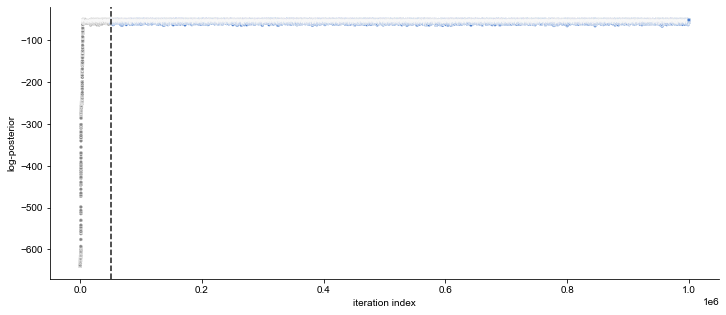

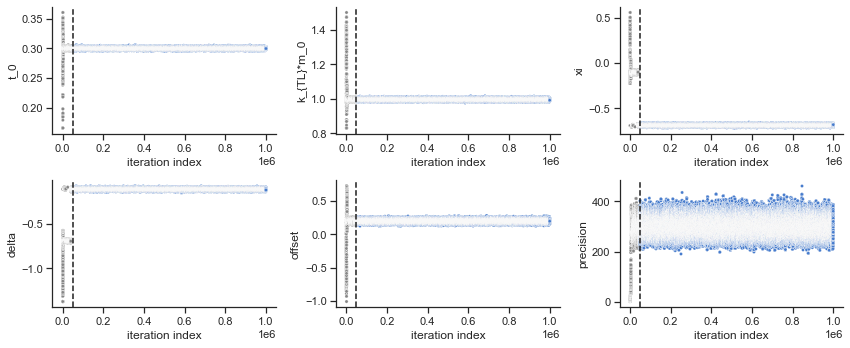

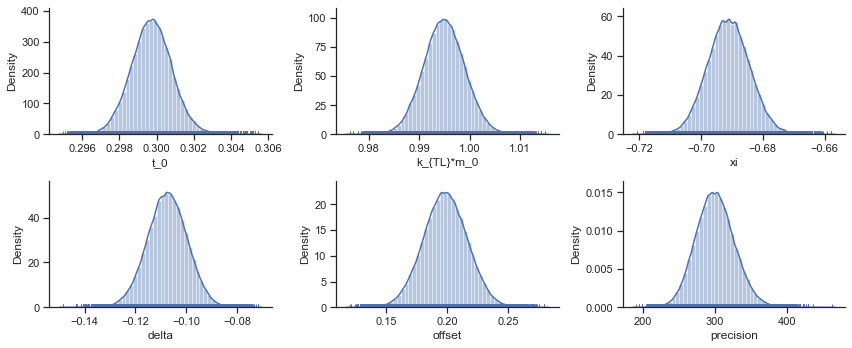

In [10]:
# Visualize the log posterior trace
ax = visualize.sampling_fval_trace(result, size=(12,5), full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))

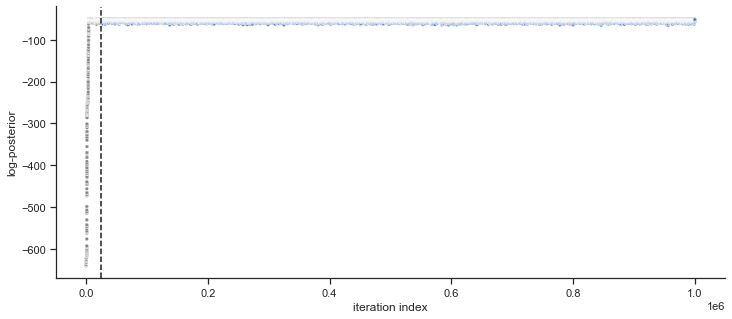

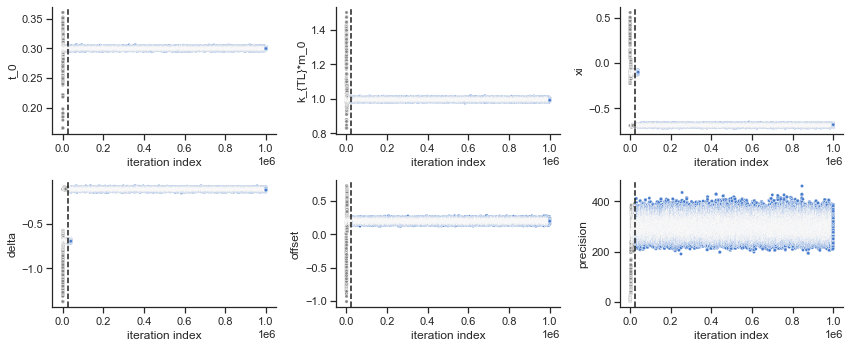

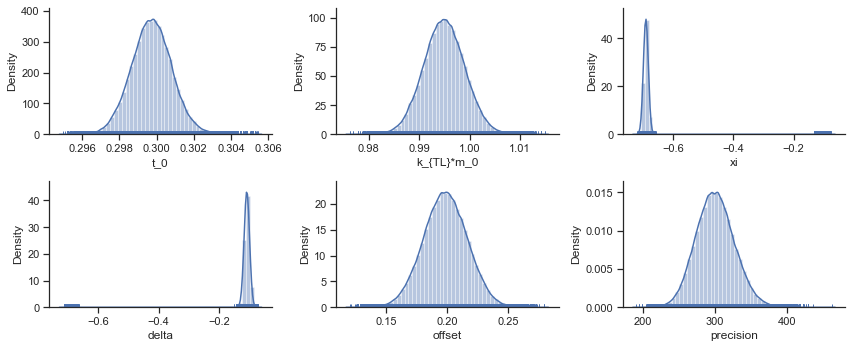

In [11]:
result.sample_result.burn_in = 25000
# Visualize the log posterior trace
ax = visualize.sampling_fval_trace(result, size=(12,5), full_trace=True)
# Visualize the parameter trace
ax = visualize.sampling_parameters_trace(result, use_problem_bounds=False, full_trace=True, size=(12,5))
# Visualize the one-dimensional marginals --> Important!
ax = visualize.sampling_1d_marginals(result, size=(12,5))